In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from datetime import datetime

import tensorflow as tf
import os

In [38]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [39]:
data = pd.read_csv("order_data.csv")
data.head()

,Date,TimeOfDay,MenuItem,Quantity
0,2023-01-01,07:00,Chicken Tikka Masala,2
1,2023-01-01,07:00,Shrimp Scampi,2
2,2023-01-01,07:00,Chicken Alfredo,3
3,2023-01-01,07:00,Caesar Salad,1
4,2023-01-01,07:00,Tiramisu,3


In [40]:
def extract_hour(timestamp):
    time_obj = datetime.strptime(timestamp, '%H:%M')
    return time_obj.hour

# Applying the function to the 'TimeofDay' column to extract hours
data['TimeOfDay'] = data['TimeOfDay'].apply(extract_hour)

In [41]:
# Convert 'Date' column to datetime format and 'TimeOfDay' to timedelta format
data['DateTime'] = pd.to_datetime(data['Date']) + pd.to_timedelta(data['TimeOfDay'], unit='h')

In [42]:
# Convert 'Date' column to numeric representation
data['Date'] = pd.to_datetime(data['Date'])
start_date = data['Date'].min()
data['NumericDate'] = (data['Date'] - start_date).dt.days + 1

In [43]:
data = data.groupby(['DateTime', 'Date', 'NumericDate', 'TimeOfDay', 'MenuItem']).agg({'Quantity': 'sum'}).reset_index()
data.head(5)

,DateTime,Date,NumericDate,TimeOfDay,MenuItem,Quantity
0,2023-01-01 07:00:00,2023-01-01,1,7,Beef Stroganoff,5
1,2023-01-01 07:00:00,2023-01-01,1,7,Beef Tacos,4
2,2023-01-01 07:00:00,2023-01-01,1,7,Breakfast Combo,1
3,2023-01-01 07:00:00,2023-01-01,1,7,Caesar Salad,1
4,2023-01-01 07:00:00,2023-01-01,1,7,Chicken Alfredo,3


In [44]:
label_encoders = {}
categorical_columns = ['MenuItem']

for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col]) + 1

data.head()

,DateTime,Date,NumericDate,TimeOfDay,MenuItem,Quantity
0,2023-01-01 07:00:00,2023-01-01,1,7,1,5
1,2023-01-01 07:00:00,2023-01-01,1,7,2,4
2,2023-01-01 07:00:00,2023-01-01,1,7,3,1
3,2023-01-01 07:00:00,2023-01-01,1,7,4,1
4,2023-01-01 07:00:00,2023-01-01,1,7,5,3


In [45]:
X = data[['NumericDate', 'TimeOfDay', 'MenuItem']]
y = data['Quantity']

In [46]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Convert X and y to numpy arrays
X_array = X.values  # Convert DataFrame to numpy array
y_array = y.values
print(X_array.shape[0], X_array.shape[1])
# Reshape X to match the input shape expected by the LSTM layer
X_reshaped = X_array.reshape(X_array.shape[0], 1, X_array.shape[1])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_array, test_size=0.4, random_state=42)

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(units=128, activation='tanh', input_shape=(1, 3)))
model.add(Dense(units=1))  # Output layer for regression (single value prediction)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=50)

50100 3
Epoch 1/50
602/602 [==============================] - 7s 10ms/step - loss: 57.8557
Epoch 2/50
602/602 [==============================] - 6s 9ms/step - loss: 52.8928
Epoch 3/50
602/602 [==============================] - 6s 9ms/step - loss: 51.7791
Epoch 4/50
602/602 [==============================] - 6s 10ms/step - loss: 51.1324
Epoch 5/50
602/602 [==============================] - 6s 9ms/step - loss: 50.3709
Epoch 6/50
602/602 [==============================] - 6s 9ms/step - loss: 49.6607
Epoch 7/50
602/602 [==============================] - 6s 9ms/step - loss: 48.9018
Epoch 8/50
602/602 [==============================] - 5s 9ms/step - loss: 48.1530
Epoch 9/50
602/602 [==============================] - 5s 9ms/step - loss: 47.5244
Epoch 10/50
602/602 [==============================] - 5s 9ms/step - loss: 47.2141
Epoch 11/50
602/602 [==============================] - 6s 9ms/step - loss: 46.4327
Epoch 12/50
602/602 [==============================] - 6s 9ms/step - loss: 46.2414
Epo

In [55]:
# Prediction
predicted_values_ = model.predict(X_test)

627/627 [==============================] - 2s 3ms/step


In [56]:
mse = mean_squared_error(y_test, predicted_values_)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted_values_)
r2 = r2_score(y_test, predicted_values_)

print("Before rounding the predictions")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) for LSTM model:", r2)

Mean Squared Error (MSE): 34.94167345704301
Root Mean Squared Error (RMSE): 5.911148235076076
Mean Absolute Error (MAE): 4.847113105265086
R-squared (R2) for LSTM model: 0.3812711531694333


In [57]:
predicted_values_ = np.round(predicted_values_)

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
# Calculate Mean Squared Error (MSE)

mse = mean_squared_error(y_test, predicted_values_)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted_values_)
r2 = r2_score(y_test, predicted_values_)

print("After rounding the predictions")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) for LSTM model:", r2)

Mean Squared Error (MSE): 35.027744510978046
Root Mean Squared Error (RMSE): 5.918424157744868
Mean Absolute Error (MAE): 4.846007984031936
R-squared (R2) for LSTM model: 0.3797470520409574


1/1 [==============================] - 0s 14ms/step


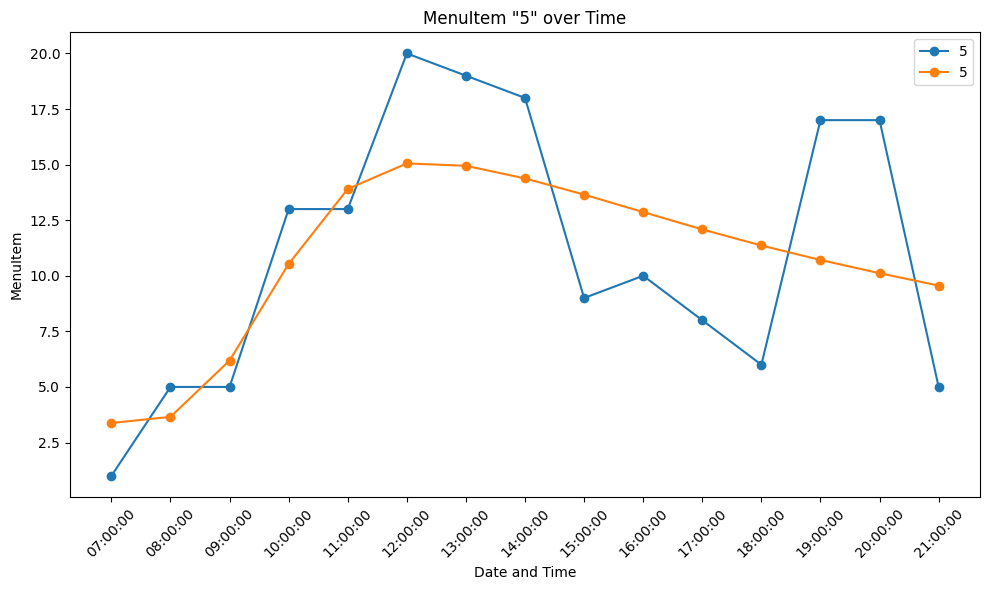

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' contains your dataset with columns NumericDate, TimeOfDay, MenuItem

# Convert 'Date' column to datetime format and 'TimeOfDay' to timedelta format
data['DateTime'] = pd.to_datetime(data['Date']) + pd.to_timedelta(data['TimeOfDay'], unit='h')

# Selecting features (including the combined datetime column) and MenuItem
X = data[['DateTime', 'NumericDate', 'TimeOfDay', 'MenuItem', 'Quantity']]

# Filter for a specific date and menu item
selected_date = '2023-01-16'  # Replace with your desired date in 'YYYY-MM-DD' format
selected_menu_item = 5  # Replace with the menu item you want to plot


s_d = X[(X['DateTime'].dt.date == pd.to_datetime(selected_date).date()) & (X['MenuItem'] == selected_menu_item)]
# Selecting features for the specific menu item
X_d = s_d[['NumericDate', 'TimeOfDay', 'MenuItem']]
y_d = s_d['Quantity']


X_d_reshaped = X_d.values.reshape(X_d.shape[0], 1, X_d.shape[1])
# Predicting for the specific menu item using the already trained model
predictions_d = model.predict(X_d_reshaped)

selected_data = X[(X['DateTime'].dt.date == pd.to_datetime(selected_date).date()) & (X['MenuItem'] == selected_menu_item)]
plt.figure(figsize=(10, 6))
plt.plot(selected_data['DateTime'].dt.strftime('%H:%M:%S'), selected_data['Quantity'], marker='o', linestyle='-', label=selected_menu_item)
plt.plot(selected_data['DateTime'].dt.strftime('%H:%M:%S'), predictions_d, marker='o', linestyle='-', label=selected_menu_item)
plt.xlabel('Date and Time')
plt.ylabel('MenuItem')
plt.title(f'MenuItem "{selected_menu_item}" over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [60]:
from tensorflow.keras.models import save_model

# Save the model
model.save("adam_50_epochs_tanh.h5")

/Users/pramodsaji/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
